# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 6

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter6 import *

In [3]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, \
ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

# Rock, Paper, Scissors

## Rock Paper Scissors Dataset

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

In [4]:
# This may take a couple of minutes...
download_rps()

rps folder already exists!
rps-test-set folder already exists!


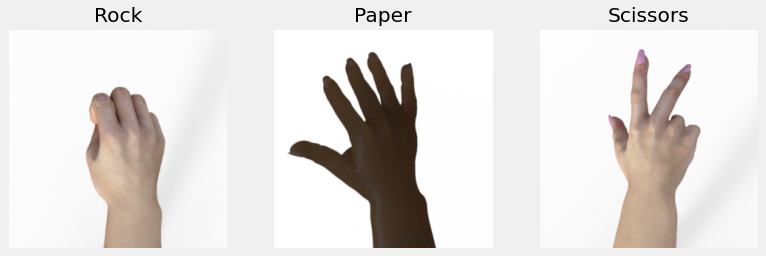

In [5]:
fig = figure1()

# Data Preparation

There are three classes once again, so we can use what we learned in Chapter 5.

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images (for real this time, no min-max scaling anymore!).
Besides, we can use the `ImageFolder` dataset now

## ImageFolder

This is not a dataset itself, but a generic dataset that you can use with your own
images provided that they are properly organized into sub-folders, each sub-folder
named after a class and containing the corresponding images.

The "Rock-Paper-Scissors" dataset **is organized like that**: inside the rps folder of
the training set, there are **three sub-folders named after the three classes** (rock,
paper, and scissors).

The dataset is also **perfectly balanced**, each sub-folder containing 840 images of its
particular class.

The `ImageFolder` dataset requires only the root folder, which is the rps folder in
our case. But it can take another four optional arguments:

- `transform`: you know that one already, it tells the dataset which transformations should be applied to each image, like the data augmentation transformations we’ve seen in previous chapters
- `target_transform`: so far, our targets have always been integers, so this argument wouldn’t make sense; but it starts making sense if your target is also an image (for instance, in a segmentation task)
- `loader`: a function that loads an image from a given path, in case you’re using weird or atypical formats that cannot be handled by PIL
- `is_valid_file`: a function that checks if a file is corrupt or not

Let’s create a dataset then:

*Temporary dataset*

In [6]:
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

We’re using only the transform optional argument here, and keeping transformations to a minimum.

First, images are **resized to 28x28 pixels** (and automatically transformed to RGB
color model by the PIL loader, thus losing the alpha channel), and then **converted
to PyTorch’s tensors**. Smaller images will make our models faster to train, and
more "CPU-friendly". 

Let’s take the first image of the dataset and check its shape
and corresponding label:

In [7]:
temp_dataset[0][0].shape, temp_dataset[0][1]     # image, label

(torch.Size([3, 28, 28]), 0)

## Standardization

To standardize data points, we need to **learn its mean and standard deviation first.**

What’s the mean pixel value of our rock-paper-scissors images? And standard
deviation? To compute them, we need to load the data. The good thing is, we have a
(temporary) dataset with the resized images already! We’re only missing a **data
loader.**

In [8]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

No need to bother with shuffling, this is **not the data loader we’ll use to train** the
model anyway. We’ll use it to compute statistics only. By the way, we need
statistics for each channel, as required by the `Normalize` transform.

So, let’s build a function that takes a mini-batch (images and labels), and computes
the **mean pixel value and standard deviation per channel of each image**, adding up
the results for all images. Better yet, let’s make it a method of our StepByStep class
too.

In [9]:
@staticmethod
def statistics_per_channel(images, labels):
    # NCHW
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten HW into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)

    # Computes statistics of each image per channel
    # Average pixel value per channel 
    # (n_samples, n_channels)
    means = flatten_per_channel.mean(axis=2)
    # Standard deviation of pixel values per channel
    # (n_samples, n_channels)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    
    # Makes a tensor of shape (1, n_channels)
    # with the number of samples in the mini-batch
    n_samples = torch.tensor([n_samples]*n_channels).float()
    
    # Stack the three tensors on top of one another
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [10]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

Applying it to the first mini-batch of images, we get the results above: each column
represents a channel, and the rows are the number of data points, the sum of mean
values, and the sum of standard deviations, respectively.

We can leverage the `loader_apply` method we created in the last chapter to get
the **sums for the whole dataset**:

In [11]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [12]:
a, b, c = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
a

tensor([2520., 2520., 2520.])

So, we can compute the **average mean value** (that sounds weird, I know), and the
average standard deviation, per channel. Better yet, let’s make it a method that
takes a data loader and returns an instance of the `Normalize transform`, statistics
and all:



In [13]:
@staticmethod
def make_normalizer(loader):
    total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
    norm_mean = total_means / total_samples
    norm_std = total_stds / total_samples
    return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

> IMPORTANT: always use the training set to compute statistics
for standardization!

Now, we can use it to create a transformation that **standardizes** our dataset:

In [14]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

Remember that PyTorch converts the pixel values into the [0, 1] range. The
average mean value of a pixel, for the red (first) channel, is 0.8502, while its
average standard deviation is 0.2089.

> In the next chapter, we’ll use **pre-computed statistics** to
standardize the inputs when using a **pre-trained model**.

### The Real Datasets

It’s time to build our *real* datasets using the Normalize transform with the statistics
we learned from the (temporary) training set. The data preparation step looks like
this:

In [15]:
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

Even though the second part of the dataset was named rps-test-set by its author,
we’ll be using it as our validation dataset. 

Since each dataset, training and validation, corresponds to a different folder, there is no need to split anything.

Next, we use both datasets to create the corresponding data loaders, remembering
to shuffle the training set now.

Let’s take a peek at some images from the real training set:

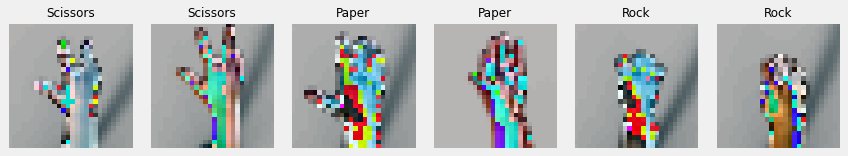

In [16]:
torch.manual_seed(88)
first_images, first_labels = iter(train_loader).next()

fig = figure2(first_images, first_labels)

> "What’s wrong with the colors?"

There is nothing wrong with the colors, it is just the effect of the standardization
of the pixel values. Now that we have colored images, we can take a step back into
the convolution world and see how it handles…

## Three-Channel convolutions

Convolutions Over Multiple Channels

Before, there was a single channel image and a single channel filter. Or many filters,
but all of them still having a single channel. Now, there is a three-channel image
and a three-channel filter. Or many filters, but all of them still having three
channels.

> Every filter has as many channels as the image it is convolving.

Convolving a three-channel filter over a three-channel image **still produces a
single value**, as depicted in the figure below:

![](./images/3channel1.png)

We can think of it as **performing three convolutions**, each corresponding to the
element-wise multiplication of the matching region/channel and filter/channel,
**resulting in three values**, one for each channel. **Adding up the results for each
channel produces the expected single value**. 

The figure below should illustrate it better:

![](./images/3channel2.png)

We can also look at it in code if you prefer:

In [17]:
regions = np.array([[[[5, 0, 8],
                      [1, 9, 5],
                      [6, 0, 2]],
                     [[0, 5, 4],
                      [8, 1, 9],
                      [4, 8, 1]],
                     [[4, 2, 0],
                      [6, 3, 0],
                      [5, 2, 8]]]])
regions.shape

(1, 3, 3, 3)

In [18]:
three_channel_filter = np.array([[[[0, 3, 0],
                                   [1, 0, 1],
                                   [2, 1, 0]],
                                  [[2, 1, 0],
                                   [0, 3, 1],
                                   [1, -1, 0]],
                                  [[0, 1, 3],
                                   [-1, -2, 0],
                                   [2, 0, 1]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [19]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[39]]]], dtype=torch.int32), torch.Size([1, 1, 1, 1]))

> "What if I have two filters?"

Glad you asked! The figure below illustrates the fact that **every filter has as many
channels as the image being convolved**.

![](./images/3channel_filters1.png)

If you have two filters, and the input image has three channels, each filter has
three channels as well, and the output has two channels.

> The convolution produces as many channels as there are filters.

OK, it is time to develop a…

## Fancier Model

Let’s leave the `Sequential` model aside for now and build a model class once again.

This time, our constructor method will take two arguments: `n_filters` and `p`. We’ll
use `n_filters` as the number of output channels for both convolutional blocks of
our model (yes, there are two now!). And, as you can see from the code below, we’ll
use `p` as the probability of dropout.

**init***

There are two convolutional layers, and two linear layers, fc1 (the hidden layer)
and fc2 (the output layer).

> "Where are the layers for activation functions and max-pooling?"

Well, the max-pooling layer **doesn’t learn anything**, so we can use its functional
form: `F.max_pool2d`. The same goes for the chosen activation function: `F.relu`.

> If you choose the parametric ReLU (PReLU), you shouldn’t use
the functional form since it needs to learn the coefficient of
leakage (the slope of the negative part).

On the one hand, you keep the model’s attributes to a minimum. On the other hand,
you don’t have **layers to hook** anymore, so you cannot capture the output of
activation functions and max-pooling operations anymore.

Let’s create our two convolutional blocks in a function aptly named **featurizer**:

**featurizer**

This structure, where an argument x is both input and output of every operation in
a sequence, is fairly common. The featurizer produces a feature tensor of size n_filters times 25.
The next step is to build the classifier using the linear layers, one as a hidden layer,
the other as the output layer. 

But there is more to it: there is a dropout layer before each linear layer, and it will drop values with a probability p (the second argument of our constructor method):

**forward**

It takes the inputs (a mini-batch of images, in this case), runs them through the
featurizer first, and then runs the produced features through the classifier, which
produces three logits, one for each class.

In [20]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50) 
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)
        
    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x
    
    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x
                
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Dropout

Dropout is an important piece of deep learning models. It is used as a **regularizer**,
that is, it tries to **prevent overfitting** by forcing the model to find more than one
way to achieve the target.

The general idea behind regularization is that, if left unchecked, **a model will try to
find the "easy way out"** (can you blame it?!) to achieve the target. What does it
mean? It means it may end up relying on a handful of features because these
features were found to be more relevant in the training set. Maybe they are, maybe
they aren’t… it could very well be a statistical fluke, who knows, right?

To make the model more robust, some of the features are randomly denied to it, so
it has to achieve the target in a different way. It makes **training harder but it should
result in better generalization**, that is, the model should perform better when
handling unseen data (like the data points in the validation set).

The whole thing looks a lot like the randomization of features used in random
forests to perform the splits. Each tree, or even better, each split has access to a
subset of features only.

> "How does this "feature randomization" works in a deep learning model?"

To illustrate it, let’s build a sequential model with a single Dropout layer:

In [21]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

> "Why do I need a model for this? Can’t I use the functional form F.dropout instead?"

Yes, a functional dropout would go just fine here, but I wanted to illustrate another
point too, so please bear with me. Let’s also create some neatly spaced points to
make it easier to understand the effect of dropout.

In [22]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

Next, let’s use these points as inputs of our amazingly simple model:

In [23]:
torch.manual_seed(44)

dropping_model.train()

output_train = dropping_model(spaced_points)

output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

There are many things to notice here:

- the model is in **train mode** (very important, hold on to this!)
- since this model does not have any weights, it becomes clear that dropout drops inputs, not weights
- it dropped four elements only
- the remaining elements have different values now!


First, dropping is probabilistic, so each input had a 50% chance of being dropped.
In our tiny example, by chance, only four out of ten were actually dropped (hold on
to this thought too!).

![](images/dropout_paper.png)

Second, the remaining elements need to be proportionally adjusted by a factor of
1/p. In our example, that’s a factor of two.

In [24]:
output_train / spaced_points

tensor([0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 2.])

> "Why?"

This adjustment has the purpose of **preserving (or at least trying to) the overall
level of the outputs in that particular layer** that’s "suffering" the dropout. So, let’s
imagine these inputs (after dropping) will feed a **linear layer** and, for educational
purposes, that all its weights are equal to one (and bias equals zero). As you
already know, a linear layer will multiply these weights by the (dropped) inputs and
sum them up:

In [25]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

The sum is 9.4. It would have been half of it (4.7) without the adjusting factor.

> "OK, so what? Why do I need to preserve the level of the outputs anyway?"

Because **there is no dropping in evaluation mode!** We’ve talked about it briefly in
the past… the dropout is random in nature, so it would produce slightly (or maybe
not so slightly) different predictions for the same inputs. You don’t want that,
that’s bad business. So, let’s set our model to eval mode (and that’s why I chose to
make it a model instead of using functional dropout) and see what happens there:

In [26]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

Pretty boring, right? This isn’t doing anything!

> Finally, an actual difference in behavior between train and eval modes! It was long overdue!

The inputs are just passing through. What’s the implication of this? Well, that
linear layer that receives these values is still multiplying them by the weights and
summing them up:

In [27]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

This is the sum of all inputs (because all the weights were set to one and no input
was dropped). If there was **no adjusting factor, the outputs in evaluation and
training mode would be substantially different**, simply because there would be
more terms to add up in evaluation mode.

> "I am still not convinced… **without adjusting** the output would be
4.7, which is **closer to 6.6** than the adjusted 9.4… what is up?"

This happened because dropping is **probabilistic**, and only four out of ten elements
were actually dropped (that was the thought I asked you to hold on to). 

**The factor adjusts for the average number of dropped elements**. We set the probability to
50% so, on average, five elements will be dropped. 

By the way, if you change the seed to 45 and re-run the code, it will actually drop half of the inputs, and the adjusted output will be 6.4 instead of 9.4.

Instead of setting a different random seed and manually checking which value it
produces, let’s generate 1,000 scenarios and compute the sum of the adjusted
dropped outputs to get their distribution:

In [28]:
torch.manual_seed(17)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p), 
                                         weight=torch.ones(11), bias=torch.tensor(0)) 
                                for _ in range(1000)])

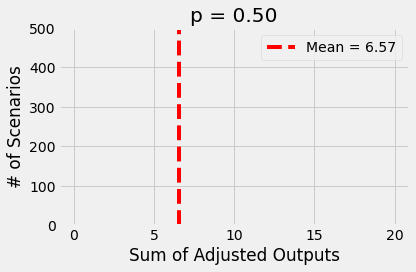

In [29]:
fig = figure7(p, distrib_outputs)

The figure above shows us that, for that set of inputs, the output of our simple
linear layer with dropout will not be exactly 6.6 anymore, but something between
0 and 12. The mean value for all scenarios is *quite close* to 6.6, though.

> Dropout not only **drops some inputs but, due to its probabilistic
nature, produces a distribution of outputs.**

> In other words, the model needs to learn **how to handle a distribution of values that is centered at the value the output would have if there was no dropout.**

Moreover, the choice of the **dropout probability** determines how **spread the outputs** will be:

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter6.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


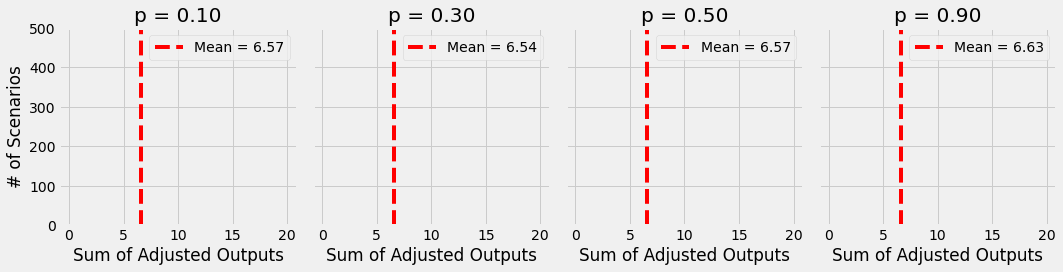

In [30]:
fig = figure8()

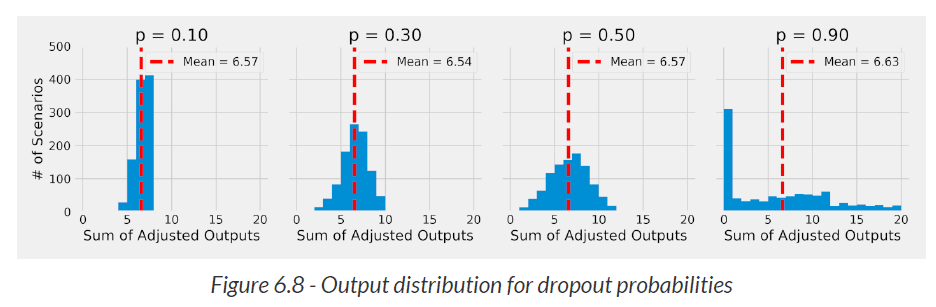

On the left, if there is barely any dropout (p=0.10), the sum of adjusted outputs is
tightly distributed around the mean value. For more **typical dropout probabilities**
(like 30% or 50%), the distribution may take some **more extreme values.**

If we go to **extremes**, like a dropout probability of 90%, the distribution gets a bit
degenerated, I would say… it is pretty much all over the place (and it has a lot of
scenarios where everything gets dropped, hence the tall bar at zero).


> The **variance of the distribution of outputs grows with the
dropout probability.**
A higher dropout probability makes it harder for your model to
learn - that’s what regularization does.


> "Can I use dropout with the convolutional layers?"

### Two-Dimensional Dropout

Yes, you can, but not that dropout. There is a **specific dropout** to be used with
convolutional layers: `nn.Dropout2d`. Its dropout procedure is a bit different,
though: instead of dropping individual inputs (which would be pixel values in a
given channel), **it drops entire channels/filters**. 

So, if a convolutional layer produces 10 filters, a two-dimensional dropout with a probability of 50% would drop five filters (on average), while the remaining filters would have all their pixel
values left untouched.

> "Why does it drop entire channels instead of dropping pixels?"

Randomly dropping pixels doesn’t do much for regularization because **adjacent
pixels are strongly correlated**, that is, they have quite similar values. You can think
of it this way: if there are some dead pixels randomly spread in an image, the
missing pixels can probably be easily filled with the values of the adjacent pixels.

On the other hand, if a full channel is dropped (in an RGB image), the color changes
(good luck figuring the values for the missing channel!).

The figure below illustrates the effect of both, regular and two-dimensional,
dropout procedures on an image of our dataset:

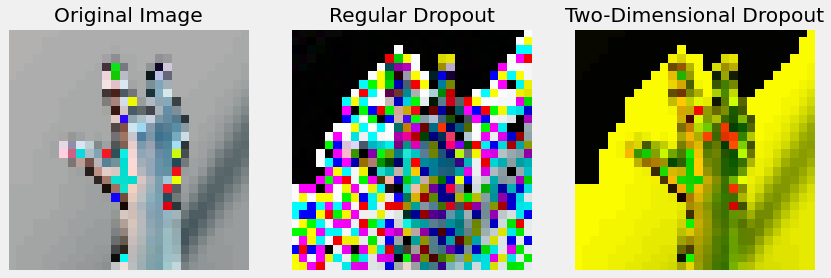

In [31]:
fig = figure9(first_images)

Sure, in deeper layers, there is no correspondence between channel and color
anymore, **but each channel still encodes some feature**. By randomly dropping some
channels, two-dimensional dropout achieves the desired regularization.

Now, let’s make it a bit harder for our model to learn by setting its dropout
probability to 30% and observing how it fares…

## Model Configuration

The configuration part is short and straightforward: *we create a model, a loss
function, and an optimizer*.

The model will be an instance of our `CNN2` class with **five filters** and a **dropout
probability of 30%**. Our dataset has three classes, so we’re using a
`CrossEntropyLoss` (which will take the three logits produced by our model).

#### Optimizer

Regarding the optimizer, let’s ditch the SGD optimizer and use **Adam** for a change.

Stochastic gradient descent is simple and straightforward, as we’ve learned in
Chapter 0, but it is also slow. So far, the training speed of SGD was not an issue
because our problems were quite simple. But, as our models grow a bit more
complex, we can benefit from choosing a different optimizer.


> Adaptive Moment Estimation (Adam) uses **adaptive learning
rates**, **computing a learning rate for each parameter**. Yes, you
read it right: each parameter has a learning rate to call its own!

> If you dig into the state_dict of an Adam optimizer, you’ll find
tensors shaped like the parameters of every layer in your model
that Adam will use to compute the corresponding learning rates.
True story!

**Adam** is known to achieve good results fast and it is likely a safe choice of optimizer.
We’ll get back to its inner workings in a later section.


#### Learning rate

Another thing we need to keep in mind is that 0.1 won’t cut as learning rate anymore. Remember what happens when the learning rate is too big? The loss
doesn’t go down or, even worse, goes up! **We need to go smaller**, much smaller
than that. For this example, let’s use 3e-4, the **"Karpathy’s Constant"[97]**. Even
though it was meant as a joke, it still is in the right order of magnitude, so let’s give
it a try.

In [32]:
torch.manual_seed(13)
model_cnn2 = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

## Model Training

Once again, we use our StepByStep class to handle model training for us.

In [33]:
sbs_cnn2 = StepByStep(model_cnn2, multi_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

You should expect training to take a while since this model is more complex than
previous ones (6823 parameters against 213 parameters for the last chapter’s
model). After it finishes, the computed losses should look like this:

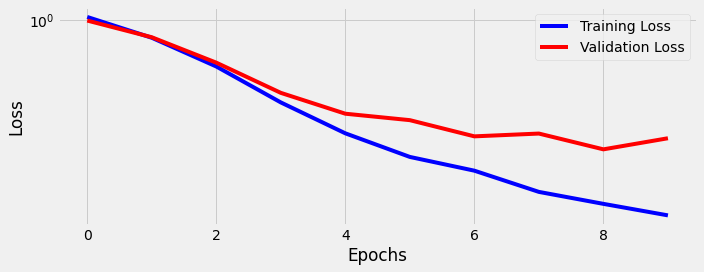

In [34]:
fig = sbs_cnn2.plot_losses()

### Accuracy

We can also check the model’s accuracy for each class:

In [35]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 93, 124],
        [119, 124],
        [114, 124]])

The model got 313 out of 372 right. That’s 84.1% accuracy on the validation set -
not bad!

### Regularizing Effect

Dropout layers are used for **regularizing**, that is, they should **reduce overfitting
and improve generalization**. Or so they say :-)

Let’s (empirically) verify this claim by training a model identical in every way *BUT* the
dropout, and **compare their losses and accuracy.**

In [36]:
torch.manual_seed(13)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
sbs_cnn2_nodrop = StepByStep(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
sbs_cnn2_nodrop.set_loaders(train_loader, val_loader)
sbs_cnn2_nodrop.train(10)

Then we can plot the losses of the model above (no dropout) together with the losses from our previous model (30% dropout):

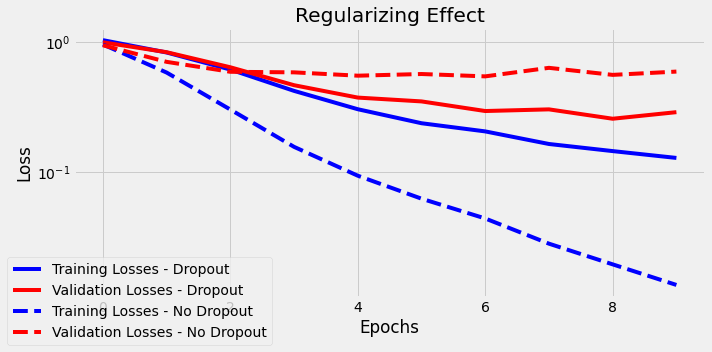

In [37]:
fig = figure11(sbs_cnn2.losses, sbs_cnn2.val_losses, sbs_cnn2_nodrop.losses, sbs_cnn2_nodrop.val_losses)

This is actually a very nice depiction of the **regularizing effect of using dropout**:

- **training loss is bigger with dropout** - after all, dropout makes training harder
- **validation loss is smaller with dropout** - it means that the model is generalizing better and achieving a better performance on unseen data, which is the whole point of using a regularization method like dropout.

We can also observe this effect by looking at the **accuracies** for both sets and
models. First, the **no dropout** model, which is expected to overfit to the training
data:

In [38]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2_nodrop.correct).sum(axis=0), 
    StepByStep.loader_apply(val_loader, sbs_cnn2_nodrop.correct).sum(axis=0)
)

tensor([2520, 2520]) tensor([293, 372])


That’s 99.92% accuracy on the training set! And 78.76% on the validation set…
smells like overfitting!

Then, let’s look at the regularized version of the model:

In [39]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2.correct).sum(axis=0),
    StepByStep.loader_apply(val_loader, sbs_cnn2.correct).sum(axis=0)
)

tensor([2504, 2520]) tensor([326, 372])


That’s 99.36% accuracy on the training set - still quite high! But we got 84.13% on
the validation set now… a narrower gap between training and validation accuracy is always a good sign. You can also try different probabilities of dropout and observe how much better (or worse!) the results get.

### Visualizing Filters

There are **two** convolutional layers in this model, let’s visualize them! For the first
one, conv1, we got:

In [40]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

Its shape indicates it produced **five filters** for each one of the three input channels
(15 filters in total), and each filter is 3x3 pixels.

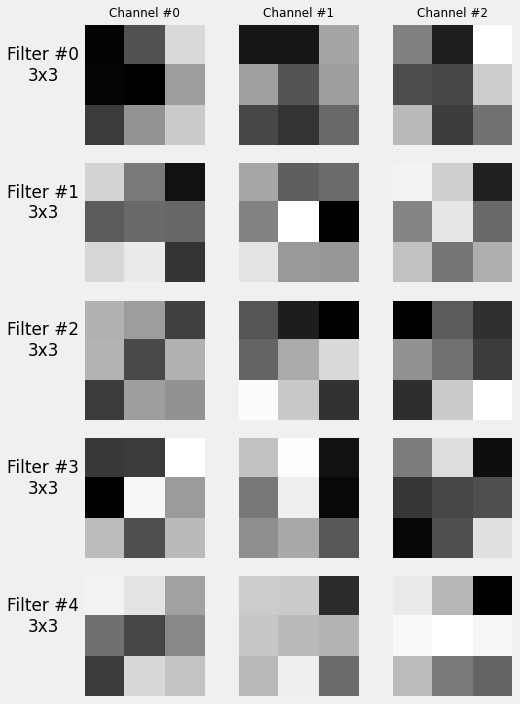

In [41]:
fig = sbs_cnn2.visualize_filters('conv1')

For the second convolutional layer, `conv2`, we got:

In [42]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

Its shape indicates it produced five filters for each one of the five input channels (25 filters in total), and each filter is 3x3 pixels.

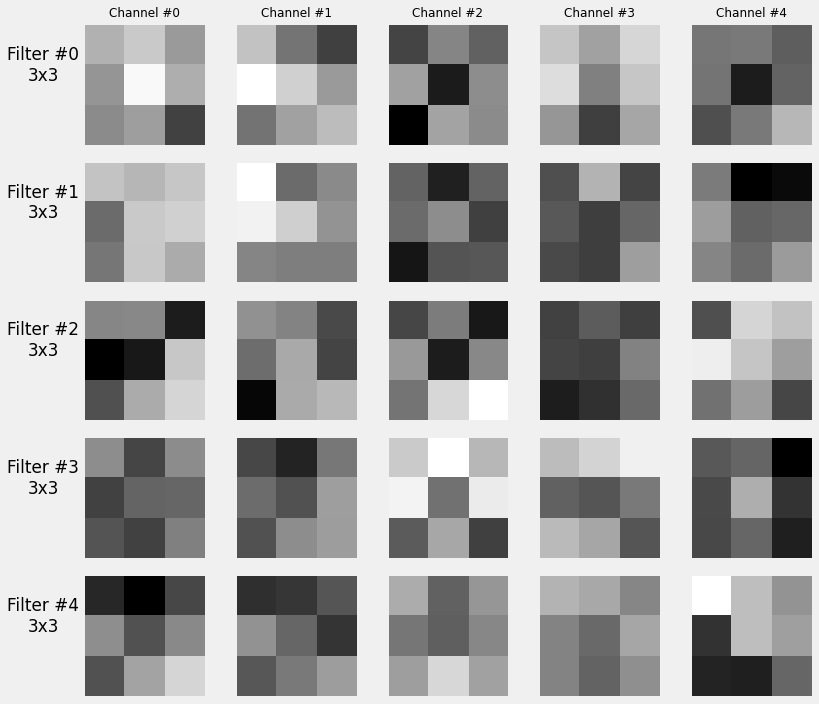

In [43]:
fig = sbs_cnn2.visualize_filters('conv2')

## Learning Rates

It is time to have **"the talk"**… it cannot be postponed any longer, we need to talk
about **choosing a learning rate!** It is no secret that the learning rate is the most
important hyper-parameter of all - it drives the **update of the parameters**, that is, it
drives how fast a model learns (hence, learning rate).

Choosing a learning rate that works well for a given model (and dataset) is a difficult task, mostly done by trial-and-error since there is no analytical way of
finding the optimal learning rate. One thing we can say for sure is that it should be
**less than 1.0**, and it is likely bigger than **1e-6**.

> "Well, that doesn’t help much…"

Indeed, it doesn’t. So, let’s discuss how we can make it a bit more specific than that.

In previous chapters, we used 0.1 as the learning rate, which is kinda big but
worked well for really simple problems. As models grow more complex, though,
that value is definitely too big for them, and one order of magnitude smaller (0.01)
is a better starting point.

> "What if it is still too big and the loss doesn’t go down?"

That’s a real possibility, and one possible way of handling this is to perform a **grid
search**, trying multiple learning rates over a few epochs each and comparing the
evolution of the losses. This is expensive, computationally speaking, since you need
to train the model multiple times, but **it may still be feasible if your model is not too
big**.

> "How do I choose values for the grid search?"

It is commonplace to reduce the learning rate by a **factor of 3** or a factor of 10. So,
your learning rate values could very well be `[0.1, 0.03, 0.01, 3e-3, 1e-3, 3e-
4, 1e-4]` (using a factor of 3) or `[0.1, 0.01, 1e-3, 1e-4, 1e-5]` (using a factor of
10). In general, if you plot the learning rates against their corresponding losses, this
is what you should expect:

- if the learning rate is too small, the model doesn’t learn much, and the loss remains high
- if the learning rate is too big, the model doesn’t converge to a solution, and the loss grows
- in between those two extremes, the loss should be smaller, hinting at the right order of magnitude for the learning rate

### Finding LR

It turns out, **you don’t have to grid search** the learning rate like that. In 2017, Leslie
N. Smith published *"Cyclical Learning Rates for Training Neural Networks"*[98] where he
outlines a procedure to quickly find an appropriate range for the initial learning
rate (more on the cyclical part of his paper later!). This technique is called **LR Range
Test**, and it is quite a simple solution to get a first estimate for the appropriate
learning rate.

The general idea is pretty much the same as the grid search: it tries multiple
learning rates and logs the corresponding losses. But here comes the difference: **it
evaluates the loss over a single mini-batch, and then changes the learning rate
before moving on to the next mini-batch.**

This is computationally cheap (it is performing ONE training step only for each
candidate) and it can be performed inside the same training loop.

> "Wait a minute! Wouldn’t the results be affected by the previous training steps performed using different learning rates?"

Well, technically, yes. But this is not such a big deal: first, we’re looking for a
**ballpark estimate of the learning rate, not a precise value**; second, these updates
will barely nudge the model from its initial state. It is easier to live with this
difference than to reset the model every single time.

First, we need to define the **boundaries** for the test (start_lr and end_lr), and the
**number of iterations** (num_iter) to move from one to the other. On top of that, we
can choose to change how to make the increments: linearly or exponentially. 

Let’s build a higher-order function that takes all those arguments and returns another
function, one that returns the multiplying factor given the current iteration
number:

*Higher-Order Learning Rate Function Builder*

In [44]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter    
        def lr_fn(iteration):
            return np.exp(factor)**iteration    
    return lr_fn

Now, let’s try it out: say we’d like to try **ten different learning** rates between 0.01
and 0.1, and the increments should be exponential:

In [45]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

There is a factor of 10 between the two rates. If we apply this function to a
sequence of iteration numbers, from 0 to 10, that’s what we get:

In [46]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

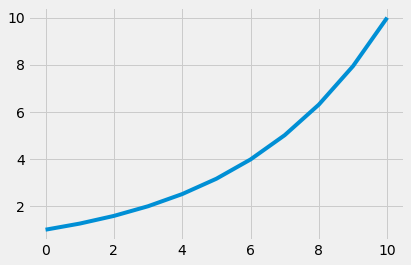

In [47]:
plt.plot(lr_fn(np.arange(num_iter + 1)))

If we multiply these values by the initial learning rate, we’ll get an array of learning rates ranging from 0.01 to 0.1 as expected:

In [48]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

> "Cool, but how do I **change the learning rate of an optimizer**?"

Glad you asked! It turns out, we can assign a **scheduler** to an optimizer, such that it
**updates the learning rate as it goes**. We’re going to dive deeper into learning rate
schedulers in a couple of sections. For now, **it suffices to know that we can make it
follow a sequence of values like the one above using a scheduler that takes a
custom function**. Coincidence? I think not! That’s what we’ll be using lr_fn for:

In [49]:
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

The `LambdaLR` scheduler takes an optimizer and a custom function as arguments
and **modifies the learning rate of that optimizer accordingly**. To make it happen,
though, we need to call the **scheduler’s step method**, but only after calling the
**optimizer’s own step method**:

In [50]:
dummy_optimizer.step()
dummy_scheduler.step()

After one step, the learning rate should have been updated to match the second
value in our array (0.01258925). Let’s double-check it using the scheduler’s `get_last_lr` method:

In [51]:
dummy_scheduler.get_last_lr()[0]

0.012589254117941673

Perfect! Now let’s build the **actual range test**. This is what we’re going to do:

- since we’ll be updating both **model and optimizer**, we need to **store their initial states** so they could be restored in the end
- create both custom function and corresponding scheduler, just like in the snippets above
- **(re)implement a training loop over mini-batches**, so we can **log the learning rate and loss at every step**
- restore model and optimizer states

Moreover, since we’re using a **single mini-batch** to evaluate the loss, the resulting
values are likely jumping up and down a lot. So, it is better to **smooth the curve
using an exponentially weighted moving average (EWMA)** (we’ll talk about
EWMAs in much more detail in the next section) to more easily identify the trend in
the values.

This is what the method looks like:

In [52]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()), 
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
    
    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(StepByStep, 'lr_range_test', lr_range_test)

Since the technique is supposed to be applied on an untrained model, we’re
creating a new model (and optimizer) here: 

In [53]:
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

Next, we create an instance of `StepByStep` and call the new method using the training data loader, the upper range for the learning rate (end_lr), and how many iterations we’d like it to try:

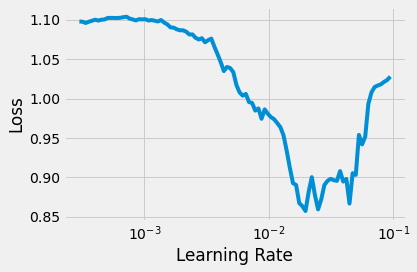

In [54]:
sbs_new = StepByStep(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

There we go, an **"U"-shaped curve**. Apparently, the Karpathy Constant (3e-4) is too
low for our model. **The descending part of the curve is the region we should aim
for**: something around 0.01.

It means **we could have used a higher learning rate**, like 0.005, to train our model.
But this also means we need to recreate the optimizer and update it in sbs_new.

First, let’s create a method for setting its optimizer:

In [55]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer
    
setattr(StepByStep, 'set_optimizer', set_optimizer)

Then, we create and set the new optimizer, and train the model as usual:

In [56]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

If you try it out, you’ll find that the training loss actually goes down a bit faster (and
that the model might be overfitting).

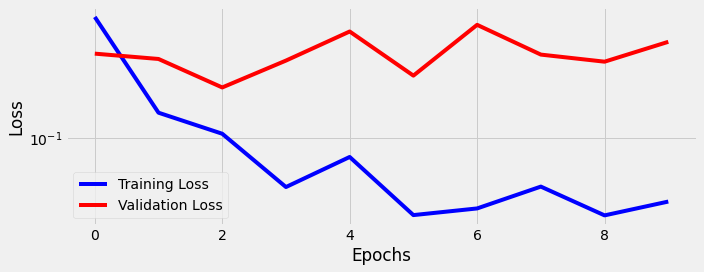

In [57]:
# This plot wasn't included in the book
fig = sbs_new.plot_losses()

> **DISCLAIMER**: the learning rate finder is surely **not magic**!
Sometimes you’ll not get the "U"-shaped curve… maybe the
initial learning rate (as defined in your optimizer) is **too big
already**, or maybe the end_lr is too small. Even if you do, it does
not necessarily mean the mid-point of the descending part will
give you the fastest learning rate for your model.

> "OK, if I manage to choose a good learning rate from the start, am I
done with it?"

Sorry, but NO… well, it depends, it may be fine for simpler (but real, not toy)
problems. The issue here is, for bigger models, the loss surface (remember that,
from Chapter 0?) becomes very messy, and **a learning rate that works well at the
start of model training may be too big for a later stage of model training**. It means
that the learning rate needs to change or adapt…

### LRFinder

The function we’ve implemented above is fairly basic. For an implementation with more bells and whistles, check this Python package: torch_lr_finder[99]. 

I am illustrating its usage here, which is quite similar to what we’ve done above, but please refer to the documentation for more details.

In [58]:
#!pip install --quiet torch-lr-finder

In [59]:
from torch_lr_finder import LRFinder

# VAMOS PAGINA 512.

Instead of calling a function directly, we need to create an instance of
LRFinder first, using the typical model configuration objects (model,
optimizer, loss function, and the device). Then, we can take the range_test
method for a spin, providing familiar arguments to it: a data loader, the upper
range for the learning rate, and the number of iterations. The reset method
restores the original states of both model and optimizer.

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-02


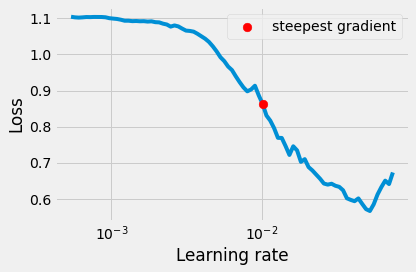

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

Not quite a "U" shape, but we still can tell that something in the ballpark of
1e-2 is a good starting point.

### Adaptive Learning Rate

That’s what the Adam optimizer is actually doing for us… it starts with the
learning rate provided as an argument, but **it adapts the learning rate(s) as it goes,
tweaking it** in a different way for each parameter in the model. Or does it?

Truth to be told, **Adam does not adapt the learning rate, it really adapts the
gradients**. But, since the parameter update is given by the multiplication of both
terms, the learning rate and the gradient, **this is a distinction without a difference.**


Adam combines the characteristics of two other optimizers: `SGD` (with **momentum**)
and `RMSProp`. Like the former, it uses a moving average of gradients instead of
gradients themselves (that’s the first moment, in statistics jargon); like the latter, it
scales the gradients using a moving average of squared gradients (that’s the
second moment, or uncentered variance, in statistics jargon).

But this is not a simple average. It is a moving average. And it is not any moving
average. It is **an exponentially weighted moving average (EWMA).**
Before diving into EWMAs, though, we need to briefly go over simple moving
averages.

#### Moving Average (MA)

To compute the moving average of a given feature x over a certain number of
periods, we just have to average the values observed over that many time steps
(from an initial value observed periods+1 steps ago all the way up to the current
value):

$$
\large
\text{MA}_t(\text{periods}, x) = \frac{1}{\text{periods}}(x_t + x_{t-1} + \ldots + x_{t-\text{periods}+1})
$$

But, instead of averaging the values themselves, let’s compute the **average age of
the values**. The current value has an age equals one unit of time while the oldest
value in our moving average has an age equals periods units of time, so the
average age is given by the formula below:

$$
\large
\text{average age}_{\text{MA}} = \frac{1+2+\cdots+\text{periods}}{\text{periods}} = \frac{\text{periods}+1}{2}
$$

For a five-period moving average, the average age of its values is three units of
time.

> "Why do we care about the average age of the values?"

This may seem a bit silly in the context of a simple moving average, sure. But, as
you’ll see in the next subsection, an **EWMA does not use the number of periods
directly in its formula**: we’ll have to rely on **the average age of its values** to
estimate its (equivalent) number of periods.

> "Why use an EWMA then?"

#### EWMA

An EWMA is more practical to compute than a traditional moving average because
it has only **two inputs**: the value of EWMA in the **previous step** and the current
value of the variable being averaged. There are two ways of representing its
formula, using alpha or beta:

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) = &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{EWMA}_t(\beta, x) = &(1-\beta) &x_t &+ &\beta &\text{EWMA}_{t-1}(\beta, x)
\end{array}
$$

The first alternative, using alpha as the **weight of the current value** is most
common in other fields, like finance. But, for some reason, the beta alternative is
the one commonly found when the Adam optimizer is discussed.

Let’s take the first alternative and expand the equation a bit:

$$
\large
\begin{array}
&\text{EWMA}_t(\alpha, x) &= &&\alpha x_t &+& (1-\alpha)\ (\alpha x_{t-1} &+& (1-\alpha)\ \ \text{EWMA}_{t-2}(\alpha, x))
\\
&= &&\alpha x_t &+& (1-\alpha)\ \ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} + \ldots
\\
&= &\ (1-\alpha)^0& \alpha x_{t-0} &+& (1-\alpha)^1\ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} + \ldots
\\
&= \alpha& ((1-\alpha)^0&\ \ x_{t-0} &+& (1-\alpha)^1\ \ \ x_{t-1} &+& (1-\alpha)^2\ \ x_{t-2} + \ldots)
\\
\end{array}
$$

The first element is taken at face value, but all the remaining elements are
discounted based on their corresponding lags.

> "What is a lag?"

It is simply the **distance**, in units of time, **from the current value**. So, the value of
feature $x$ one time unit in the past is the value of feature x at lag one.

After working out the expression above, we end up with an expression where each
term has an **exponent** depending on the corresponding number of lags. We can use
this information to make a sum out of it:

$$
\large
\text{EWMA}_t(\alpha, x) = \alpha \sum_{\text{lag}=0}^{T-1}\underbrace{(1-\alpha)^{\text{lag}}}_{\text{weight}} x_{t-\text{lag}}
$$

In the expression above, **T** is the **total number of observed values**. So, an EWMA
takes every value into account, no matter how far in the past it is. But, due to the
weight (the discount factor), *the older a value gets, the less it contributes to the
sum*.

> Higher values of alpha correspond to **rapidly shrinking weights**, that is, older values barely make a difference.

Let’s see how the weights are distributed over the lags for two averages, an EWMA with alpha equals one third and a simple five-period moving average:

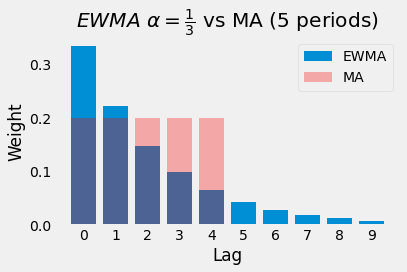

In [61]:
fig = figure15()

See the difference? In a simple **moving average** every value has the same weight,
that is, they contribute equally to the average. But, in an EWMA, more recent
values have larger weights than older ones.

It may not seem like it, but the two averages above have something in common.
The average age of its values is approximately the same. Cool, right?

So, **if the average age of the values in a five-period moving average is three, we
should arrive at (approximately) the same value for the age of the values in the
EWMA above**. Let’s understand why this is so. Maybe you haven’t noticed it yet,
but a lag of zero corresponds to an age of one unit of time, a lag of one
corresponds to an age of two units of time, and so on. We can use this information
to compute the average age of the values in an EWMA:

$$
\large
\text{average age}_{\text{EWMA}} = \alpha \sum_{\text{lag}=0}^{T-1}(1-\alpha)^{\text{lag}} (\text{lag}+1) \approx \frac{1}{\alpha}
$$

As the total number of observed values (T) grows, the average age approaches the
inverse of alpha. No, I am not demonstrating this here. Yes, I am showing you a
snippet of code that "proves" it numerically :-)

You may go bananas with the value of T, trying in vain to approach infinity, but 20
periods is more than enough to make a point:

In [62]:
alpha = 1/3; T = 93
t = np.arange(1, T + 1)
age = alpha * sum((1 - alpha)**(t - 1) * t)
age

3.0

Now that we know how to compute the average age of an EWMA given its alpha,
we can figure out which (simple) moving average has the same average age:

$$
\large
\text{average age} = \frac{\text{periods} + 1}{2} = \frac{1}{\alpha} \implies \alpha = \frac{2}{\text{periods}+1};\ \text{periods} = \frac{2}{\alpha}-1
$$

There we go, an easy and straightforward relationship between **the value of alpha
and the number of periods of a moving average**. 

Guess what happens if you plug the value one-third for alpha? 

You get the corresponding number of periods: five. An EWMA using alpha equals one-third corresponds to a five-period moving average.


It also works the other way around: if we’d like to compute the EWMA equivalent
to a 19-period moving average, the corresponding alpha would be 0.1. And, if
we’re using the EWMA’s formula based on beta, that would be 0.9. Similarly, to
compute the EWMA equivalent to a 1999-period moving average, alpha and beta
would be 0.001 and 0.999, respectively.

These choices are not random at all: it turns out, Adam uses these two values for
its betas (one for the moving average of gradients, the other for the moving
average of squared gradients).

In code, the implementation of the alpha version of EWMA looks like this:

In [63]:
def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

For computing it over a series of values, given a period, we can define a function
like this:

In [64]:
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

In the try..except block, you can see that, if there is no previous value for the
EWMA (as in the very first step), it assumes a previous value of zero.

The way the EWMA is constructed has its issues… since it does not need to keep
track of all the values inside its period, **in its first steps, the "average" will be way
off (or biased)**. For an alpha=0.1 (corresponding to the 19 periods average), the
very first "average" will be exactly the first value divided by ten.
To address this issue, we can compute the bias-corrected EWMA:

$$
\large \text{Bias Corrected EWMA}_t(x, \beta) = \frac{1}{1 - \beta^t}\text{EWMA}_t(x, \beta)
$$

The beta in the formula above is the same as before: 1 - alpha. In code, we can
implement the correction factor like this:

In [65]:
def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

For computing the corrected EWMA over a series of values, we can use a function
like this:

In [66]:
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)
    
    alpha = 2 / (period + 1)
    beta = 1 - alpha
    
    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)
        
    return np.array(result)

Let’s apply both EWMAs, together with a regular moving average, to a sequence of
temperature values to illustrate the differences:

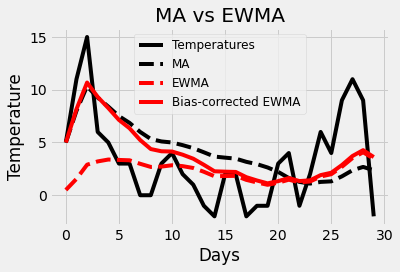

In [67]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1, 
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])

fig = ma_vs_ewma(temperatures, periods=19)

As expected, the EWMA without correction (red dashed line) is way off at the
beginning, while the regular moving average (black dashed line) tracks the actual
values much closer. The corrected EWMA, though, does a very good job tracking
the actual values from the very beginning. Sure enough, after 19 days, both
EWMAs are barely distinguishable.

#### EWMA Meets Gradients

Who cares about temperatures, anyway? Let’s apply the EWMAs to our gradients,
Adam-style!

For **each parameter**, we compute **two EWMAs**: one for its gradients, **the other for
the square of its gradients**. Next, we use both values to compute the adapted
gradient for that parameter:

$$
\large \text{adapted-gradient}_t = \frac{\text{Bias Corrected EWMA}_t(\beta_1, \text{gradients})}{\sqrt{\text{Bias Corrected EWMA}_t(\beta_2, \text{gradients}^2)}+\epsilon}
$$

There they are, Adam’s beta1 and beta2 parameters! Its **default values, 0.9 and
0.999, correspond to averages of 19 and 1999 periods**, respectively.

So, it is a **short term average for smoothing the gradients**, and a very long term average **for scaling the gradients**. The epsilon value in the denominator (usually 1e-8) is there to prevent numerical issues only.

Once the adapted gradient is computed, it replaces the actual gradient in the
parameter update:

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\end{aligned}
$$

Clearly, the **learning rate (the Greek letter eta) is left untouched!**

Moreover, due to the scaling, the adapted gradient is likely to be inside the `[-3, 3]`
range most of the time (this is akin to the standardization procedure but without
subtracting the mean).

#### Adam

So, choosing the Adam optimizer is an easy and straightforward way to tackle your
learning rate needs. Let’s take a closer look at PyTorch’s Adam optimizer and its
arguments:

- `params`: model’s parameters
- `lr`: learning rate, default value 1e-3
- `betas`: tuple containing beta1 and beta2 for the EWMAs
- `eps`: the epsilon (1e-8) value in the denominator

The four arguments above should be clear by now. But there are another two we
haven’t talked about yet:

- `weight_decay`: L2 penalty
- `amsgrad`: if the AMSGrad variant should be used

The first argument, `weight_decay`, introduces a regularization term (L2 penalty) to
the model’s weights. As every regularization procedure, it aims at **preventing
overfitting by penalizing weights with large values**. The term weight decay comes
from the fact that the regularization actually increases the gradients by adding the
weight value multiplied by the weight decay argument.

> "If it increases the gradients, how come it is called weight decay?"

In the parameter update, the gradient is multiplied by the learning rate and
subtracted from the weight’s previous value. So, in effect, **adding a penalty to the
value of the gradients makes the weights smaller**. The smaller the weights, the
smaller the penalty, thus making further reductions even smaller - in other words -
the weights are decaying.

The second argument, `amsgrad`

The first argument, `weight_decay`, introduces a regularization term (L2 penalty) to
the model’s weights. As every regularization procedure, it aims at **preventing
overfitting by penalizing weights with large values**. The term weight decay comes
from the fact that the regularization actually increases the gradients by adding the
weight value multiplied by the weight decay argument.

> "If it increases the gradients, how come it is called weight decay?"

In the parameter update, the gradient is multiplied by the learning rate and
subtracted from the weight’s previous value. So, in effect, **adding a penalty to the
value of the gradients makes the weights smaller**. The smaller the weights, the
smaller the penalty, thus making further reductions even smaller - in other words -
the weights are decaying.

The second argument, `amsgrad`, makes the optimizer compatible with a variant of
the same name. In a nutshell, it modifies the formula used to compute adapted
gradients, ditching the bias correction, and using the peak value of the EWMA of
squared gradients instead.

For now, we’re sticking with the first four, well-known to us, arguments:

In [68]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

#### Visualizing Adapted Gradients

Now, I’d like to give you the chance of **visualizing the gradients**, the EWMAs, and
the resulting adapted gradients. To make it easier, let’s bring back our simple
linear regression problem from "Part I" of this book, and, somewhat nostalgically,
let’s perform the training loop so that we can log the gradients.

> From now on and until the end of the "Learning Rates" section,
we’ll be ONLY using the simple linear regression dataset to
illustrate the effects of different parameters on the minimization
of the loss. We’ll get back to the "Rock, Paper, Scissors" dataset in
the "Putting It All Together" section.

First, we generate the data points again and run the typical data preparation step
(building dataset, splitting it, and building data loaders):

In [69]:
%run -i Scripts/data_generation/simple_linear_regression.py
%run -i Scripts/data_preparation/v2.py

Then, we go over the model configuration and change the optimizer from SGD to
Adam:

In [78]:
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

We would be ready to use the StepByStep class to train our model if it weren’t for a
minor detail: **we still do not have a way of logging gradients**. So, let’s tackle this
issue by adding yet **another method to our class**: `capture_gradients`. Like the
`attach_hooks` method, it will take a list of layers that should be monitored for their
gradient values.

For each monitored layer, it will go over its parameters and, for those that require
gradients, it will create a logging function (log_fn) and register a hook for it in the
tensor corresponding to the parameter.

The logging function simply appends the gradients to a list in the dictionary entry
corresponding to the layer and parameter names. The dictionary itself, `_gradients`,
is an attribute of the class (which will be created inside the constructor method, but
we’re setting it manually using setattr for now). The code looks like this:

In [71]:
setattr(StepByStep, '_gradients', {})

def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    self._gradients = {}
    
    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return

setattr(StepByStep, 'capture_gradients', capture_gradients)

> IMPORTANT: the logging function must return `None`, otherwise
the gradients will be modified, assuming the returned value.
The register_hook method registers a backward hook to a
tensor for a given parameter. The hook function takes a
gradient as input and returns either a modified gradient or None.

> The hook function will be called every time a gradient with
respect to that tensor is computed.
Since we’re using this function for logging purposes, we should
leave the gradients alone and return None.

> "Isn’t there a `register_backward_hook` method? Why aren’t we
using it?"

That’s a fair question. At the time of writing, this method still has an unsolved issue,
so we’re following the recommendation of using `register_hook` for individual
tensors instead.

Now, we can use the new method to log gradients for the linear layer of our model,
never forgetting to **remove the hooks** after training:

In [79]:
sbs_adam = StepByStep(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader, val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

By the time training is finished, we’ll have collected two series of 50 gradients each
(each epoch has five mini-batches), each series corresponding to a parameter of
linear (weight and bias), both of them stored in the  `_gradients` attribute of our
StepByStep instance.

We can use these values to compute the EWMAs and the **adapted gradients
actually used by Adam** to update the parameters. Let’s do it for the weight
parameter:

In [80]:
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

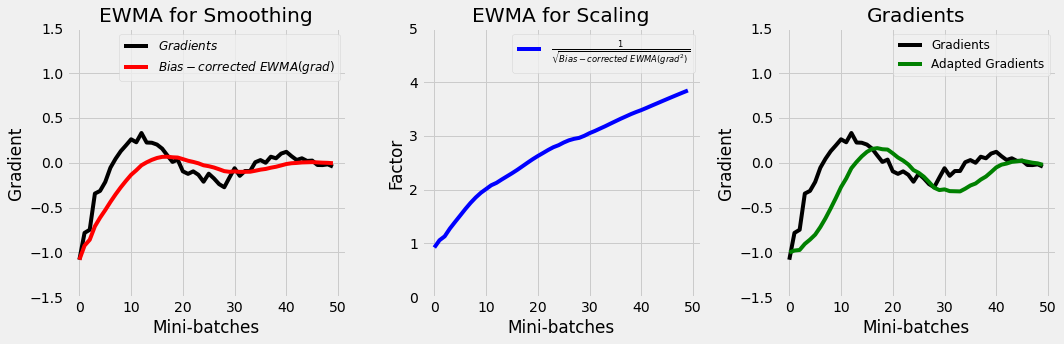

In [81]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

On the left plot, we see that the bias-corrected EWMA of gradients (in red) is
smoothing the gradients. In the center, the bias-corrected EWMA of squared
gradients is used for scaling the smoothed gradients. On the right, both EWMAs
are combined to compute the adapted gradients.

Under the hood, Adam keeps two values for each paramete: `exp_avg` and
`exp_avg_sq`, representing the (uncorrected) EWMAs for gradients and squared
gradients, respectively. We can take a peek at it using the optimizer’s state_dict:

In [82]:
optimizer.state_dict()

{'state': {0: {'step': 50,
   'exp_avg': tensor([[-0.0062]], device='cuda:0'),
   'exp_avg_sq': tensor([[0.0033]], device='cuda:0')},
  1: {'step': 50,
   'exp_avg': tensor([0.0405], device='cuda:0'),
   'exp_avg_sq': tensor([0.0097], device='cuda:0')}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1]}]}

Inside its state key, it contains two other dictionaries (with weird numeric keys)
representing the different parameters of the model. In our example, the first
dictionary (140614347109072) corresponds to the `weight` parameter. Since we’ve
logged all the gradients, we should be able to use our `calc_ewma` function to
replicate the values contained in the dictionary:

In [83]:
calc_ewma(gradients, 19)[-1], calc_ewma(np.power(gradients, 2), 1999)[-1]

(-0.006161491869941049, 0.003308466751066604)

Taking the last values of our two uncorrected EWMAs, we matched the state of
the optimizer (exp_avg and exp_avg_sq). Cool!

> "OK, cool, but how is it better than SGD in practice?"

Fair enough! We’ve been discussing how different the parameter update is, but
now it is time to show how it affects model training. Let’s bring back the loss
surface we’ve computed for this linear regression (way back in Chapter 0) and
visualize the path taken by each optimizer to bring both parameters (closer) to
their optimal values.

That would be great, but we’re missing another minor detail: **we also do not have a
way of logging the evolution of parameters**. Guess what we’re gonna do about
that? Create another method, of course!

The new method, aptly named `capture_parameters` works in a way similar to
`capture_gradients`. It keeps a dictionary (parameters) as an attribute of the class
and register forward hooks to the layers we’d like to log the parameters for. The
logging function simply loops over the parameters of a given layer and appends its
values to the corresponding entry in the dictionary. The registering itself is handled
by a method we developed earlier: attach_hooks. The code looks like this:

In [85]:
setattr(StepByStep, '_parameters', {})

def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules}
    
    self._parameters = {}
    
    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name: {}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})
            
    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())
    
    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return
    
setattr(StepByStep, 'capture_parameters', capture_parameters)

What’s next? We need to create two instances of `StepByStep`, each using a
different optimizer, set them to capture parameters, and train them for ten epochs.
The captured parameters (bias and weight) will draw the following paths (the red
dot represents their optimal values):

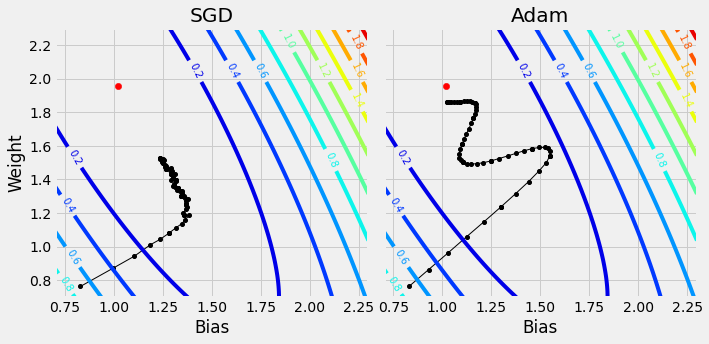

In [86]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
             'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

On the left plot, the typical well-behaved (and slow) path taken by simple gradient
descent. You can see it is wiggling a bit due to the noise introduced by using minibatches.
On the right plot, we see the effect of using the exponentially weighted
moving averages: on the one hand, it is smoother and moves faster, on the other
hand, it overshoots and has to change course back and forth as it approaches the
target. It is adapting to the loss surface if you will.


> If you like the idea of visualizing (and animating) the paths of
optimizers, make sure to check out Louis Tiao’s tutorial[100] on the
subject.

Talking about losses, we can also compare the trajectories of training and
validation losses for each optimizer:

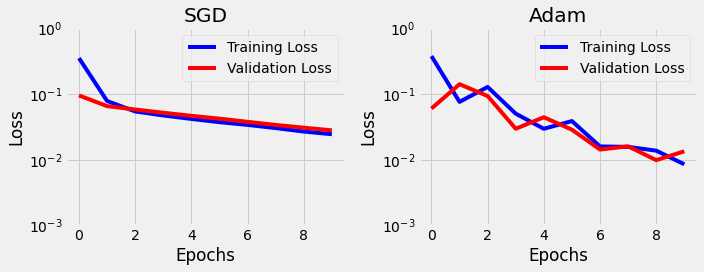

In [87]:
fig = plot_losses(results)

Remember, the **losses are computed at the end of each epoch by averaging the
losses of the mini-batches**. On the left plot, even if SGD wiggles a bit, we can see
that every epoch shows a smaller loss than the previous one. On the right plot, the
overshooting becomes clearly visible as an increase in the training loss. But it is
also clear that Adam achieves a smaller loss because it got closer to the optimal
value (the red dot in the previous plot).

> In real problems, where it is virtually impossible to plot the loss
surface, we can look at the losses as an "executive summary" of
what’s going on. Training losses will sometimes go up before they
go down again and this is expected.

#### Stochastic Gradient Descent (SGD)

Adaptive learning rates are cool indeed, but good old Stochastic Gradient Descent
(SGD) also has a couple of tricks up its sleeve. Let’s take a closer look at PyTorch’s
SGD optimizer and its arguments:

- `params`: model’s parameters
- `lr`: learning rate
- `weight_decay`: L2 penalty

The three arguments above are already known. But there are three new
arguments:

- `momentum`: momentum factor, SGD’s own beta argument, is the topic of the next section
- `dampening`: dampening factor for momentum
- `nesterov`: enables Nesterov momentum, which is a smarter version of the regular momentum, and it also has its own section

That’s the perfect moment to dive deeper into momentum (sorry, I really cannot miss
a pun!).

### Momentum

One of SGD’s tricks is called **momentum**. At first sight, it looks very much like using an EWMA for gradients, but it isn’t. Let’s compare EWMA’s beta formulation with
momentum’s:

$$
\Large
\begin{array}
&\text{EWMA}_t &= (1-\beta) &\text{grad}_t &+ &\beta &\text{EWMA}_{t-1}
\\
\text{momentum}_t &= &\text{grad}_t &+ &\beta &\text{momentum}_{t-1}
\end{array}
$$

See the difference? It does **not average** the gradients, it runs **a cumulative sum of
"discounted" gradients**. In other words, all past gradients contribute to the sum,
but they are "discounted" more and more as they grow older. The "discount" is
driven by the beta parameter, and we can also write the formula for momentum
like this:

$$
\Large
\text{momentum}_t = \beta^0\ \text{grad}_t + \beta^1\ \text{grad}_{t-1} + \beta^2\ \text{grad}_{t-2} + \ldots + \beta^n\ \text{grad}_{t-n}
$$

> "What about the dampening factor?"

The dampening factor is a way to, well, **dampen the effect of the latest gradient**.
Instead of having its full value added, the latest gradient gets its contribution to
momentum reduced by the dampening factor. So, if the dampening factor is 0.3,
only 70% of the latest gradient gets added to momentum. Its formula is given by:

$$
\Large \text{momentum}_t = (1-\text{damp})\ \text{grad}_t + \beta\ \text{momentum}_{t-1}
$$

If the dampening factor equals the momentum factor (beta), it
becomes a true EWMA!

Similarly to Adam, SGD with momentum keeps the value of momentum for each
parameter. The beta parameter is stored there as well (momentum). We can take a
peek at it using the optimizer’s state_dict

Even though old gradients slowly fade away, contributing less and less to the sum,
very recent gradients are taken almost at their face value (assuming a typical value of 0.9 for beta and no dampening). 

This means that, given a sequence of all positive (or all negative) gradients, their sum, that is, the momentum is going up really fast (in absolute value). A large momentum gets translated into a large update since momentum replaces gradients in the parameter update:

$$
\Large
\begin{aligned}
\text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{momentum}_t
\end{aligned}
$$

This behavior can be easily visualized in the path taken by SGD with momentum:

In [96]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
             'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

In [97]:
results['SGD + Momentum']['state']

{'state': {0: {'momentum_buffer': tensor([[-0.0308]], device='cuda:0')},
  1: {'momentum_buffer': tensor([-0.1423], device='cuda:0')}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [0, 1]}]}

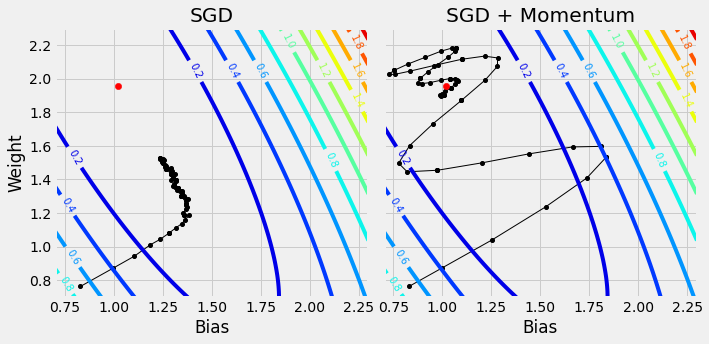

In [98]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

Like the Adam optimizer, SGD with momentum also moves faster and overshoots.
But it does seem to get carried away with it, so much so that it gets past the target
and has to backtrack to approach it from a different direction.
The analogy for the momentum update is that of a ball rolling down a hill: it picks
up so much speed that it ends up climbing the opposite side of the valley, only to roll back down again with a little bit less speed, doing this back and forth over and
over again until eventually reaching the bottom.

> "Isn’t Adam better than this already?"

Yes, and no. **Adam is indeed faster to converge to a minimum**, but not necessarily a
good one. In a simple linear regression, there is a global minimum corresponding to
the optimal value of the parameters. This is not the case of deep learning models:
there are many minima (plural of minimum), and some are better than others
(corresponding to lower losses). So, Adam will find one of these minima and move
there fast, perhaps overlooking better alternatives in the neighborhood.
**Momentum may seem a bit sloppy at first, but it may be combined with a learning
rate scheduler (more on that shortly!) to better explore the loss surface in hopes
of finding a better quality minimum than Adam.**

>  Both alternatives, Adam and SGD with momentum (especially when combined with a learning rate scheduler), are commonly used.

But, if a ball running downhill seems a bit too much out of control for your taste,
maybe you’ll like its variant better…

#### Nesterov

Nesterov Accelerated Gradient (NAG), or Nesterov for short, is a clever variant of
SGD with momentum. Let’s say we’re computing momentum for two consecutive
steps (t and t+1):

$$
\Large
\begin{array}
&\text{step t}: &&&&&&\text{mo}_t &= &\text{grad}_t &+ &\beta &\text{mo}_{t-1}
\\
\text{step t+1}: &\text{mo}_{t+1} &= &\text{grad}_{t+1} &+ &\beta &\text{mo}_{t}
\end{array}
$$

In the current step (t), we use the current gradient (t), and the momentum from the previous step (t-1) to compute the current momentum. So far, nothing new.

In the next step (t+1), we’ll use the next gradient (t+1) and the momentum we’ve
just computed for the current step (t) to compute the next momentum. Again,
nothing new.

What if I ask you to **compute momentum one step ahead?**

> "Can you tell me momentum at step t+1 while you’re still at step t?"

"Of course I can’t, I do not know the gradient at step t+1!" you say, puzzled at my
bizarre question. Fair enough. So I ask you yet another question:

> "What’s your best guess for the gradient at step t+1?"

I hope you answered, "the gradient at step t". If you do not know the future value of
a variable, the naive estimate is its current value. So, let’s go with it, Nesterov-style!

In a nutshell, what NAG does is **trying to compute momentum one step ahead** since it is only missing one value and it has a good (naive) guess for it. It is as if it was
**computing momentum between two steps**:

$$
\Large
\begin{array}
&\text{step t}: &&&&&&\text{mo}_t &= &\text{grad}_t &+ &\beta &\text{mo}_{t-1}
\\
\text{step t}: &\text{nesterov}_t &= &\text{grad}_t &+ &\beta &\text{mo}_t&
\\
\text{step t+1}: &\text{mo}_{t+1} &= &\text{grad}_{t+1} &+ &\beta &\text{mo}_{t}
\end{array}
$$

Once Nesterov’s momentum is computed, it replaces the gradient in the
parameter update, just like regular momentum:

$$
\Large
\begin{aligned}
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\end{aligned}
$$

But, Nesterov actually uses momentum, so we can expand its expression like this:

$$
\Large
\begin{aligned}
\text{param}_t & = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\\
& = \text{param}_{t-1} - \eta\ (\text{grad}_t + \beta\ \text{mo}_t)
\\
& = \text{param}_{t-1} - \eta\ \text{grad}_t - \beta\ \eta\ \text{mo}_t
\end{aligned}
$$

> "Why did you do this? What’s the purpose of making the formula more
complicated?"

You’ll understand why in a minute :-)

#### Flavors of SGD

Let’s compare the three flavors of SGD, vanilla (regular), momentum, and Nesterov,
when it comes to the way they perform the **parameter update**:

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} &&&-&& \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t &-&\beta &\eta\ \text{mo}_t
\end{aligned}
$$

That’s why I expanded Nesterov’s expression in the last section: it is easier to
compare the updates this way! 

First, there is regular SGD, which uses the gradient and nothing else. 

Then, there is momentum, which uses a "discounted" sum of past gradients (the momentum). 

Finally, there is Nesterov, which combines both (with a small tweak).

How different are the updates? Let’s check it out! The plots below show the **update**
term (before multiplying it by the learning rate) for the weight parameter of our
linear regression:

In [99]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

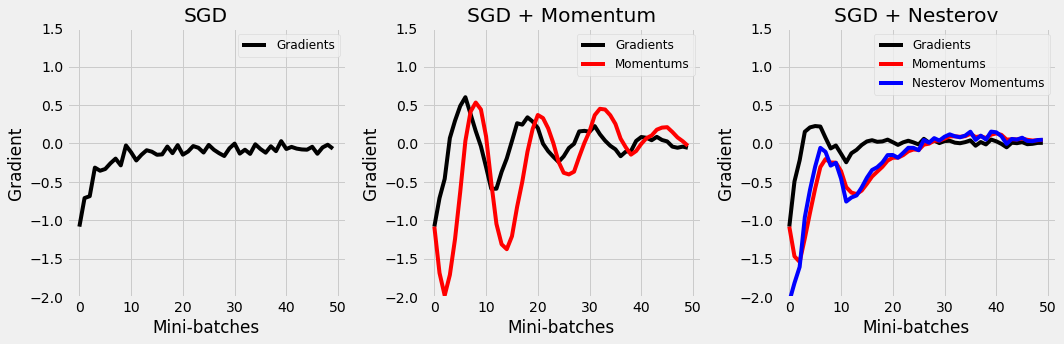

In [100]:
fig = figure21(results)

Does the shape of the update term for SGD with momentum ring a bell? The
oscillating pattern was already depicted in the path taken by SGD with momentum
while optimizing the two parameters: **when it overshoots, it has to reverse
direction, and by repeatedly doing that, these oscillations are produced.**

Nesterov momentum seems to do a better job: **the look-ahead has the effect of
dampening the oscillations** (please do not confuse this effect with the actual
dampening argument). Sure, the idea is to look ahead to avoid going too far, but
could you have told me the difference between the two plots beforehand? Me
neither! Well, I am assuming you replied "no" to this question, and that’s why I
thought it was a good idea to illustrate the patterns above.

> "How come the black lines are different in these plots? Isn’t the
underlying gradient supposed to be the same?"

The gradient is indeed computed the same way in all three flavors, but since the
update terms are different, the gradients are computed at different locations of
the loss surface. This becomes clear when we look at the paths taken by each one
of the flavors:

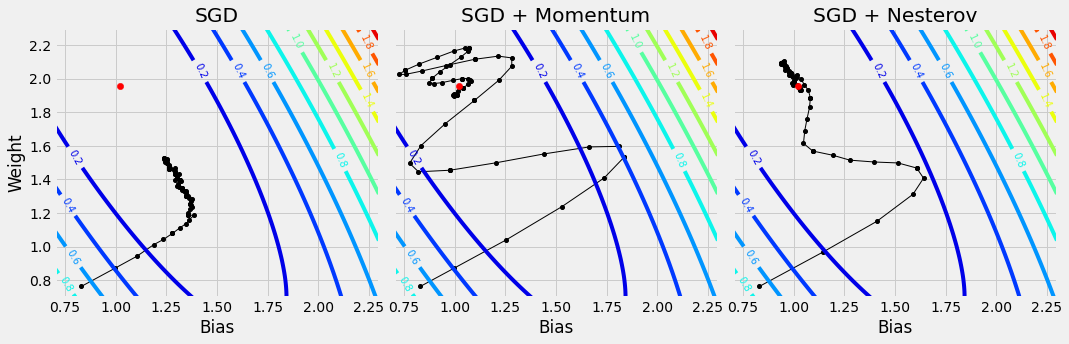

In [101]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

Take the third point in the lower left part of the black line, for instance: its location is quite different in each one of the plots and thus are the corresponding gradients.

The two plots on the left are already known to us. The new plot in town is the one
to the right. The dampening of the oscillations is abundantly clear, but Nesterov’s
momentum still gets past its target and has to backtrack a little to approach it
from the opposite direction. And let me remind you that this is one of the easiest
loss surfaces of all!

Talking about losses, let’s take a peek at their trajectories:

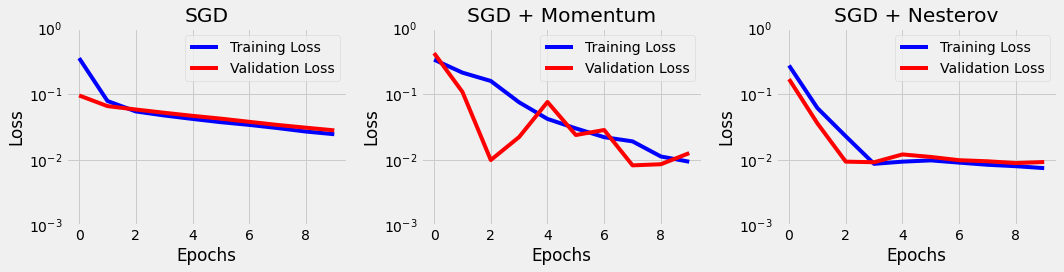

In [102]:
fig = plot_losses(results)

The plot on the left is there just for comparison, it is the same as before. The one on
the right is quite straightforward too, depicting the fact that Nesterov’s
momentum quickly found its way to a lower loss and slowly approached the
optimal value.

The plot in the middle is a bit more intriguing: even though regular momentum
produced a path with wild swings over the loss surface (each black dot
corresponds to a mini-batch), its loss trajectory oscillates less than Adam’s. 

This is an artifact of this simple linear regression problem (namely, the bowl-shaped loss surface), and should not be taken as representative of typical behavior.

If you’re not convinced by momentum, either regular or Nesterov, let’s add
something else to the mix…

### Learning Rate Schedulers

It is also possible to **schedule the changes** in the learning rate as training goes,
instead of adapting the gradients. Say you’d like to reduce the learning rate by one
order of magnitude (that is, multiplying it by 0.1) every T epochs, such that
training is faster at the beginning and slows down after a while to try avoiding
convergence problems.

> That’s what a learning rate scheduler does: it updates the
learning rate of the optimizer.

So, it should be no surprise that **one of the scheduler’s arguments is the optimizer
itself**. The learning rate set for the optimizer will be the initial learning rate of the scheduler. As an example, let’s take the simplest of the schedulers: `StepLR`, which
simply multiplies the learning rate by a factor gamma every step_size epochs.

In the code below, we create a dummy optimizer, which is "updating" some fake
parameter with an initial learning rate of 0.01. The dummy scheduler, an instance
of StepLR, will multiply that learning rate by 0.1 every two epochs.

In [103]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

**The scheduler has a step method just like the optimizer.**

> You should call the scheduler’s step method **after** calling the optimizer’s step method.

Inside the training loop, it will look like this:

In [104]:
for epoch in range(4):
    # trainin loop code goes here
    
    print(dummy_scheduler.get_last_lr())
    # First call optimizer's step
    dummy_optimizer.step()
    # Then call scheduler's step
    dummy_scheduler.step()
    
    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


As expected, it kept the initial learning rate for two epochs and then multiplied it by
0.1, resulting in a learning rate of 0.001 for another two epochs. In a nutshell, that’s
how a learning rate scheduler works.

> "Does every scheduler shrink the learning rate?"

Not really, no. It used to be standard procedure to shrink the learning rate as you
train the model, but this idea was then challenged by **cyclical learning rates** (that’s the "cyclical" part of that paper!). There are many different flavors of scheduling, as you can see. And many of them are available in PyTorch.


We’re dividing them into **three groups**: 

- schedulers that update the learning rate **every T epochs** (even if T=1), like in the example above; 
- the scheduler that only updates the learning rate when the **validation loss seems to be stuck**;
- and schedulers that update the learning rate after **every mini-batch**.


### Epoch Schedulers

These schedulers will have their step method called at the end of every epoch. But
each one has its own rules for updating the learning rate.

- `StepLR`: multiplies the learning rate by a factor gamma **every step_size** epochs
- `MultiStepLR`: multiplies the learning rate by a factor gamma at the epochs indicated in the **list of milestones**
- `ExponentialLR`: multiplies the learning rate by a factor gamma **every epoch**, no exceptions
- `LambdaLR`: takes your own **customized function** that should take the epoch as an argument and return the corresponding multiplicative factor (with respect to the initial learning rate)
- `CosineAnnealingLR`: it uses a technique called cosine annealing to update the learning rate, but we’re not delving into details here.


We can use LambdaLR to mimic the behavior of the StepLR scheduler defined above:

In [105]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))
# The scheduler above is equivalent to this one
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

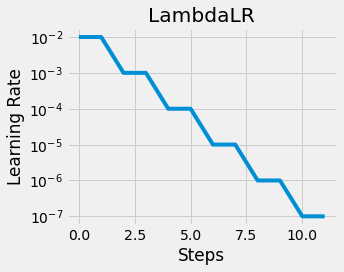

In [106]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Validation Loss Scheduler

The `ReduceLROnPlateau` scheduler should also have its step method called at the
end of every epoch, but it has its own group here because it does **not follow a
predefined schedule**. Ironic, right?

The step method **takes the validation loss as an argument**, and the scheduler can
be configured to **tolerate a lack of improvement in the loss** (to a threshold, of
course) up to a given number of epochs (the aptly named `patience` argument).

After the scheduler runs out of patience, it updates the learning rate, multiplying it
by the factor argument (for the schedulers listed in the last section, this factor was
named gamma).

To illustrate its behavior, let’s assume the validation loss remains at the same value
(whatever that is) for 12 epochs in a row. What would our scheduler do?

In [107]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

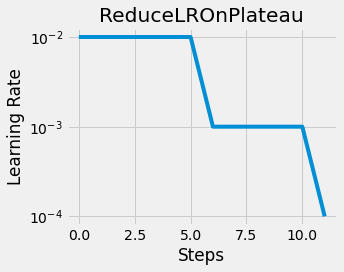

In [108]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

Its patience is **four epochs**, so after four epochs observing the same loss, it is
hanging by a thread. Then comes the fifth epoch and no change: "that’s it, the
learning rate must go down", you can almost hear it saying :-) So, in the sixth epoch,
the optimizer is already using the newly updated learning rate. If nothing changes
for four more epochs, it goes down again, as shown in the figure above.

### Scheduler in StepByStep - Part I

If we want to incorporate learning rate schedulers into our training loop, we need
to make some changes to our `StepByStep` class. Since schedulers are definitely
optional, we need to add a **method to allow the user to set a scheduler** (similarly to
what we did with TensorBoard integration). Moreover, we need to define some
attributes: one for the **scheduler** itself, and a boolean variable to distinguish if it is an epoch or a mini-batch scheduler.

In [109]:
setattr(StepByStep, 'scheduler', None)
setattr(StepByStep, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(StepByStep, 'set_lr_scheduler', set_lr_scheduler)

Next, we create a protected method that invokes the step method of the scheduler
and appends the current learning rate to an attribute, so we can keep track of its
evolution.

In [110]:
setattr(StepByStep, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_epoch_schedulers', _epoch_schedulers)

And then we modify the train method to include a call to the protected method
defined above. It should come after the validation inner loop.

In [112]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # Calls the learning rate scheduler at the end of every epoch
        self._epoch_schedulers(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Closes the writer
        self.writer.close()

setattr(StepByStep, 'train', train)

### Mini-Batch Schedulers

These schedulers will have their step method called at the end of every minibatch.
They are all cyclical schedulers.

- **CyclicLR**: it cycles between base_lr and max_lr (so it **disregards the initial learning rate set in the optimizer**), taking `step_size_up` updates to go from base to max learning rate, and `step_size_down` updates to go back. This behavior corresponds to `mode=triangular`. Additionally, it is possible to shrink the amplitude using different modes: `triangular2` will halve the amplitude after each cycle while exp_range will exponentially shrink the amplitude using gamma as base and the number of the cycle as the exponent.

> A typical choice of value for max_lr is the learning rate found using the LR Range Test.

- **OneCycleLR**: it uses a method called **annealing** to update the learning rate from its initial value up to a defined maximum learning rate (max_lr) and then down to a much smaller learning rate over a total_steps number of updates, thus performing **a single cycle**

- **CosineAnnealingWarmRestarts**: it uses cosine annealing[101] to update the learning rate, but we’re not delving into details here, except for the fact that this particular scheduler requires the epoch number (including the fractional part corresponding to the number of mini-batches over the length of the data loader) as an argument of its step method.

Let’s try `CyclicLR` in different modes for a range of learning rates between 1e-4
and 1e-3, two steps in each direction.

In [113]:
dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(.5))

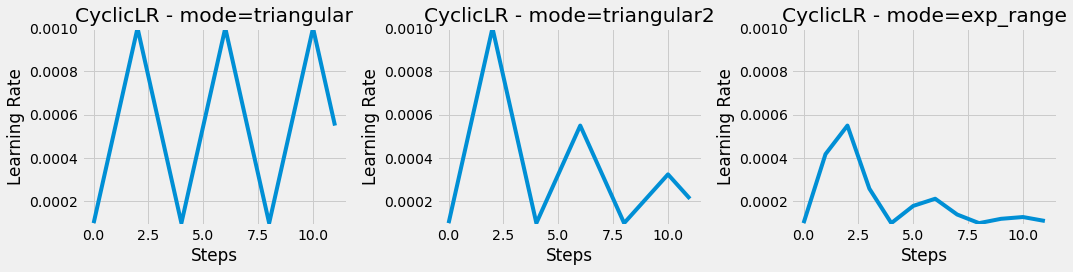

In [114]:
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

By the way, two steps means it would complete a full cycle every four mini-batch
updates - that’s completely unreasonable - and only used here to illustrate the
behavior.

> In practice, **a cycle should encompass between two and ten
epochs** (according to Leslie N. Smith’s paper), so you need to
figure how many mini-batches your training set contains (that’s
the length of the data loader) and multiply it by the desired
number of epochs in a cycle to get the total number of steps in a
cycle.

In our example, the train loader has 158 mini-batches, so if we want the learning
rate to **cycle over five epochs**, the full cycle should have 790 steps, and thus
step_size_up should be half that value (395).

### Schedulers in StepByStep - Part II

We need to make some more changes to handle **mini-batch schedulers**. Similarly to
"Part I" above, we need to create a protected method that handles the step method
of this group of schedulers.

In [115]:
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_mini_batch_schedulers', _mini_batch_schedulers)

And then we modify the mini_batch method to include a call to the protected
method defined above. It should be called at the end of the loop, **but only during
training**.

In [118]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and 
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        # Scheduler only during training
        if not validation:
            # Calls the learning rate scheduler at the end of every mini-batch update
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

### Scheduler Paths

Before trying a couple of schedulers out, let’s run an LR Range test on our model:

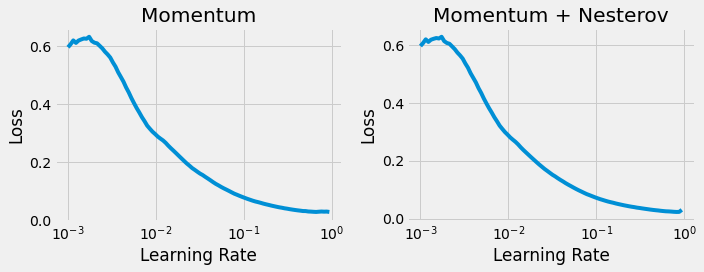

In [128]:
from stepbystep.v3 import StepByStep

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = StepByStep(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)

    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

We’re starting really small (lr=1e-3) and testing all the way up to 1.0 (end_lr) using
exponential increments. The results suggest a learning rate somewhere between
0.01 and 0.1 (corresponding to the center of the descending part of the curve). 

We know for a fact that a learning rate of 0.1 works. A more conservative choice of
value would be 0.025, for instance, since it is a midpoint in the descending part of
the curve.

Let’s be bold! First, we define the optimizer with our choice for initial learning rate
(0.1).

Then, we can pick a scheduler to bring the learning rate all the way down to 0.025.
If we choose a *step scheduler*, we can cut the learning rate in half (gamma=0.5) every
four epochs. **If we choose a cyclical scheduler, we can oscillate the learning rate
between the two extremes every four epochs (20 mini-batches, 10 up, 10 down).**

In [129]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [130]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

Applying each scheduler to SGD with momentum, and to SGD with Nesterov’s
momentum, we obtain the following paths:

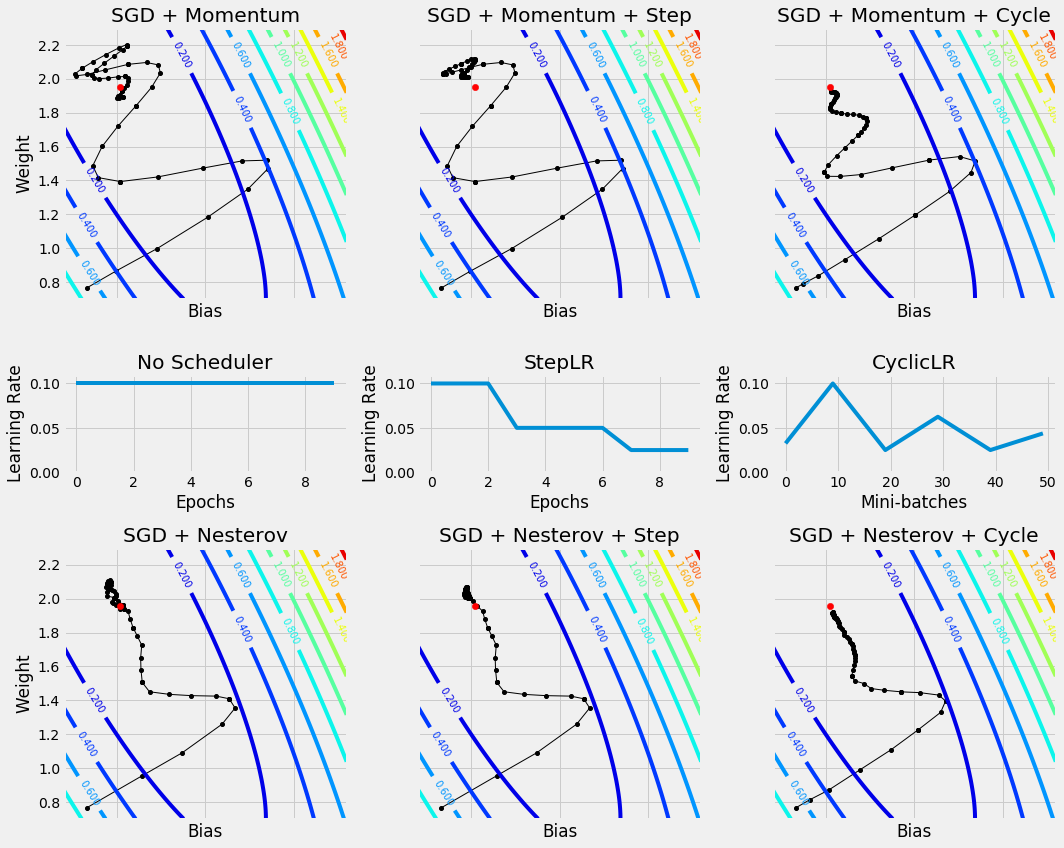

In [98]:
fig = figure28(results, b, w, bs, ws, all_losses)

Adding a scheduler to the mix seems to have helped the optimizer to achieve a
**more stable path towards the minimum**.

> The general idea of using a scheduler is to allow the optimizer to
alternate between exploring the loss surface (high learning rate
phase) and targeting a minimum (low learning rate phase).

What about the impact of the scheduler on loss trajectories? Let’s check it out:

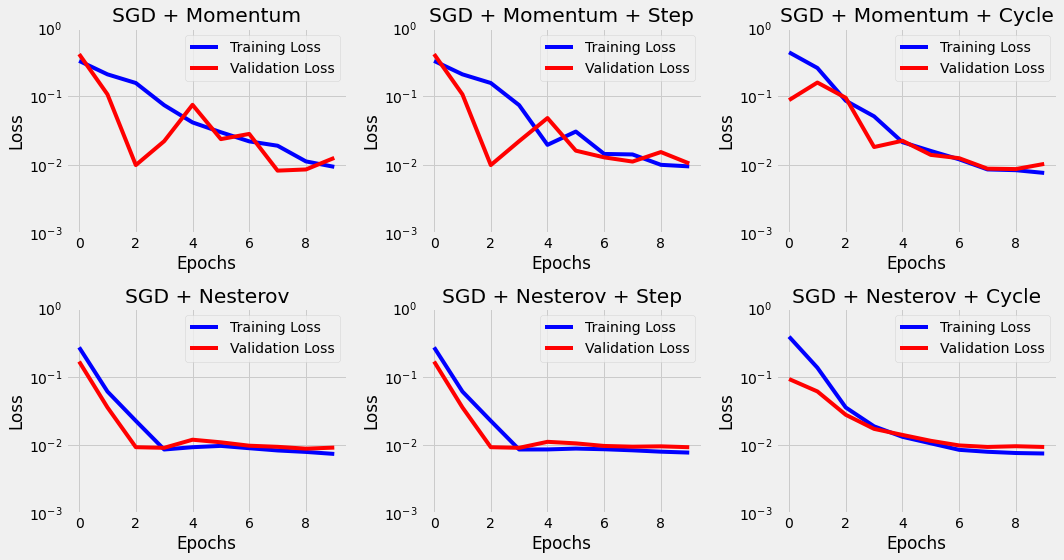

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

It is definitely harder to tell the difference between curves in the same row, except
for the combination of Nesterov’s momentum and cyclical scheduler, which
produced a smoother reduction in the training loss.

**Adaptive vs Cycling**

Although **adaptive learning rates are considered competitors of cyclical learning rates**, this does not prevent you from combining them both and cycle learning rates while using Adam. While Adam adapts the gradients using its EWMAs, the cycling policy
modifies the learning rate itself, so they can work together indeed.

There is much more to learn about in the topic of learning rates: this section is
meant to be a short introduction to the topic only.

# Putting It All Together

In this chapter, we were all over the place: data preparation, model configuration,
and model training, a little bit of everything. Starting with a brand new dataset,
"Rock, Paper, Scissors", we built a method for standardizing the images (for real this time) using a temporary data loader. Next, we developed a fancier model including
dropout layers for regularization. Then we turned our focus to the training part,
diving deeper into learning rates, optimizers, and schedulers. We implemented
many methods: for finding a learning rate, for capturing gradients and parameters,
and for updating the learning rate using a scheduler.

**Data preparation**

In [132]:
# Loads temporary dataset to build normalizer
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = StepByStep.make_normalizer(temp_loader)

# Builds transformation, datasets and data loaders
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In the model configuration part, we can use SGD with Nesterov’s momentum and a
higher dropout probability to increase regularization:

**Model configuration**

In [133]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

Before the actual training, we can run an LR Range Test:

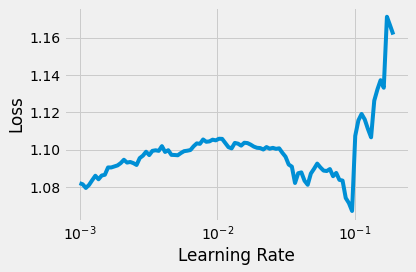

In [134]:
sbs_cnn3 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)
tracking, fig = sbs_cnn3.lr_range_test(train_loader, end_lr=2e-1, num_iter=100)

The test suggests a learning rate around 0.01, so we re-create the optimizer and
set it in our StepByStep instance.

We can also use the suggested learning rate as the **upper range** of a **cyclical
scheduler**. For its step size, we can use the length of the data loader, so the learning rate goes all the way up in one epoch, and all the way down in the next - a two-epoch cycle. 

**Updating learning rate**

In [135]:
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
sbs_cnn3.set_optimizer(optimizer_cnn3)

scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn3.set_lr_scheduler(scheduler)

After doing this, it is training as usual:

**Model training**

In [136]:
sbs_cnn3.set_loaders(train_loader, val_loader)
sbs_cnn3.train(10)

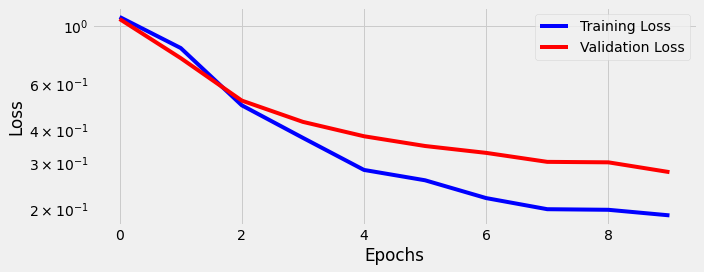

In [137]:
fig = sbs_cnn3.plot_losses()

In [138]:
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))

tensor([2511, 2520]) tensor([333, 372])


Looking good! Smaller losses, 99.64% training accuracy, and 90.32% validation
accuracy.